In [1]:
!pip install torch_geometric
!pip install matplotlib
!pip install rdkit
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
from torch_geometric.utils import degree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 30.5 MB/s eta 0:00:00
2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.0 MB/s eta 0:00:00


Load the dataset


In [3]:
import pandas as pd
from rdkit import Chem

def load_qm9_smiles(csv_file):
    # Read the CSV file containing the QM9 dataset
    df = pd.read_csv(csv_file)

    # Extract SMILES strings
    smiles_list = df['smiles'].tolist()

    return smiles_list


csv_file = "qm9.csv"
qm9_smiles = load_qm9_smiles(csv_file)
def remove_hydrogen_from_smiles(smiles_list):
    modified_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Invalid SMILES:", smiles)
            continue
        mol = Chem.RemoveHs(mol)
        modified_smiles.append(Chem.MolToSmiles(mol))
    return modified_smiles



modified_smiles = remove_hydrogen_from_smiles(qm9_smiles)
from torch_geometric.data import Data, DataLoader
def smiles_to_graph(smiles):
    # Parse the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None

    # Get node features (atomic numbers)
    atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Get edge indices (connectivity)
    edge_index = []
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edge_index.append([start_idx, end_idx])

    # Convert edge indices to PyTorch tensor
    edge_index = torch.tensor(edge_index).t().contiguous()

    # Convert node features to PyTorch tensor
    node_features = torch.tensor(atomic_numbers, dtype=torch.float).unsqueeze(1)

    return node_features, edge_index
filtered_dataset = []
for smile in modified_smiles:

    node_features, edge_index1 = smiles_to_graph(smile)
    num_nodes = node_features.shape[0]
    if num_nodes>1:
        encoding_mappings = {7: [0, 0, 1, 0, 0],
                     8: [0, 0, 0, 1, 0],
                     6: [0, 1, 0, 0, 0],
                     9: [0, 0, 0, 0, 1]}


        one_hot_encoded = torch.tensor([encoding_mappings[num.item()] for num in node_features])


        graph2 = Data(x=one_hot_encoded, edge_index=edge_index1, num_nodes=num_nodes)

        # If the graph has more than one node, add it to the filtered dataset
        filtered_dataset.append(graph2)



Model dependencies

In [4]:
from torch import nn
import torch
import math

def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    return result

class GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=0, nodes_att_dim=0, act_fn=nn.SiLU(), attention=False):
        super(GCL, self).__init__()
        input_edge = input_nf * 2
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method
        self.attention = attention

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, edge_attr, edge_mask):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target], dim=1)
        else:
            out = torch.cat([source, target, edge_attr], dim=1)

        mij = self.edge_mlp(out)

        if self.attention:
            att_val = self.att_mlp(mij)
            out = mij * att_val
        else:
            out = mij

        if edge_mask is not None:
            out = out * edge_mask
        return out, mij

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = x + self.node_mlp(agg)
        return out, agg

    def forward(self, h, edge_index, edge_attr=None, node_attr=None, node_mask=None, edge_mask=None):
        row, col = edge_index
        edge_feat, mij = self.edge_model(h[row], h[col], edge_attr, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        if node_mask is not None:
            h = h * node_mask
        return h, mij

class GNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, out_node_nf,aggregation_method='sum', device='cpu',
                 act_fn=nn.SiLU(), n_layers=4, attention=False,
                 normalization_factor=100, ):
        super(GNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        ### Encoder
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(
                self.hidden_nf, self.hidden_nf, self.hidden_nf,
                normalization_factor=normalization_factor,
                aggregation_method=aggregation_method,
                edges_in_d=in_edge_nf, act_fn=act_fn,
                attention=attention))
        self.to(self.device)

    def forward(self, h, edges, edge_attr=None, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        h = self.embedding_out(h)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h
import numpy as np

def fully_connected_graph_with_self_loops(num_nodes):
    """
    Generates edge indices for a fully connected graph with self-loops.

    Args:
        num_nodes (int): Number of nodes in the graph.

    Returns:
        torch.Tensor: Edge indices of the fully connected graph with self-loops.
    """
    # Create edge indices for a fully connected graph with self-loops
    edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes)])

    return edge_index.t().contiguous()


In [5]:

class GNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, out_node_nf,aggregation_method='sum', device='cpu',
                 act_fn=nn.SiLU(), n_layers=4, attention=False,
                 normalization_factor=100, ):
        super(GNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        ### Encoder
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(
                self.hidden_nf, self.hidden_nf, self.hidden_nf,
                normalization_factor=normalization_factor,
                aggregation_method=aggregation_method,
                edges_in_d=in_edge_nf, act_fn=act_fn,
                attention=attention))
        self.to(self.device)

    def forward(self, h, edges, edge_attr=None, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        h = self.embedding_out(h)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h
def coord2diff(x, edge_index, norm_constant=1):
    row, col = edge_index
    coord_diff = x[row] - x[col]
    radial = torch.sum((coord_diff) ** 2, 1).unsqueeze(1)
    norm = torch.sqrt(radial + 1e-8)
    coord_diff = coord_diff/(norm + norm_constant)
    return radial, coord_diff
class GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=0, nodes_att_dim=0, act_fn=nn.SiLU(), attention=False):
        super(GCL, self).__init__()
        input_edge = input_nf * 2
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method
        self.attention = attention

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, edge_attr, edge_mask):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target], dim=1)
        else:
            out = torch.cat([source, target, edge_attr], dim=1)
        mij = self.edge_mlp(out)

        if self.attention:
            att_val = self.att_mlp(mij)
            out = mij * att_val
        else:
            out = mij

        if edge_mask is not None:
            out = out * edge_mask
        return out, mij

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = x + self.node_mlp(agg)
        return out, agg

    def forward(self, h, edge_index, edge_attr=None, node_attr=None, node_mask=None, edge_mask=None):
        row, col = edge_index
        edge_feat, mij = self.edge_model(h[row], h[col], edge_attr, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        if node_mask is not None:
            h = h * node_mask
        return h, mij


class EquivariantUpdate(nn.Module):
    def __init__(self, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=1, act_fn=nn.SiLU(), tanh=False, coords_range=10.0):
        super(EquivariantUpdate, self).__init__()
        self.tanh = tanh
        self.coords_range = coords_range
        input_edge = hidden_nf * 2 + edges_in_d
        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.coord_mlp = nn.Sequential(
            nn.Linear(input_edge, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn,
            layer)
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

    def coord_model(self, h, coord, edge_index, coord_diff, edge_attr, edge_mask):
        row, col = edge_index
        input_tensor = torch.cat([h[row], h[col], edge_attr], dim=1)
        if self.tanh:
            trans = coord_diff * torch.tanh(self.coord_mlp(input_tensor)) * self.coords_range
        else:
            trans = coord_diff * self.coord_mlp(input_tensor)
        if edge_mask is not None:
            trans = trans * edge_mask
        agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        coord = coord + agg
        return coord

    def forward(self, h, coord, edge_index, coord_diff, edge_attr=None, node_mask=None, edge_mask=None):
        coord = self.coord_model(h, coord, edge_index, coord_diff, edge_attr, edge_mask)
        if node_mask is not None:
            coord = coord * node_mask
        return coord


class EquivariantBlock(nn.Module):
    def __init__(self, hidden_nf, edge_feat_nf=2, device='cpu', act_fn=nn.SiLU(), n_layers=2, attention=True,
                 norm_diff=True, tanh=False, coords_range=15, norm_constant=1, sin_embedding=None,
                 normalization_factor=100, aggregation_method='sum'):
        super(EquivariantBlock, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.coords_range_layer = float(coords_range)
        self.norm_diff = norm_diff
        self.norm_constant = norm_constant
        self.sin_embedding = sin_embedding
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=edge_feat_nf,
                                              act_fn=act_fn, attention=attention,
                                              normalization_factor=self.normalization_factor,
                                              aggregation_method=self.aggregation_method))
        self.add_module("gcl_equiv", EquivariantUpdate(hidden_nf, edges_in_d=edge_feat_nf, act_fn=nn.SiLU(), tanh=tanh,
                                                       coords_range=self.coords_range_layer,
                                                       normalization_factor=self.normalization_factor,
                                                       aggregation_method=self.aggregation_method))
        self.to(self.device)

    def forward(self, h, x, edge_index, node_mask=None, edge_mask=None, edge_attr=None):
        # Edit Emiel: Remove velocity as input
        distances, coord_diff = coord2diff(x, edge_index, self.norm_constant)
        if self.sin_embedding is not None:
            distances = self.sin_embedding(distances)
        edge_attr = torch.cat([distances, edge_attr], dim=1)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edge_index, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        x = self._modules["gcl_equiv"](h, x, edge_index, coord_diff, edge_attr, node_mask, edge_mask)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h, x


class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=3, attention=False,
                 norm_diff=True, out_node_nf=None, tanh=False, coords_range=15, norm_constant=1, inv_sublayers=2,
                 sin_embedding=False, normalization_factor=100, aggregation_method='sum'):
        super(EGNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.coords_range_layer = float(coords_range/n_layers) if n_layers > 0 else float(coords_range)
        self.norm_diff = norm_diff
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method

        if sin_embedding:
            self.sin_embedding = SinusoidsEmbeddingNew()
            edge_feat_nf = self.sin_embedding.dim * 2
        else:
            self.sin_embedding = None
            edge_feat_nf = 2

        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("e_block_%d" % i, EquivariantBlock(hidden_nf, edge_feat_nf=edge_feat_nf, device=device,
                                                               act_fn=act_fn, n_layers=inv_sublayers,
                                                               attention=attention, norm_diff=norm_diff, tanh=tanh,
                                                               coords_range=coords_range, norm_constant=norm_constant,
                                                               sin_embedding=self.sin_embedding,
                                                               normalization_factor=self.normalization_factor,
                                                               aggregation_method=self.aggregation_method))
        self.to(self.device)

    def forward(self, h, x, edge_index, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        distances, _ = coord2diff(x, edge_index)
        if self.sin_embedding is not None:
            distances = self.sin_embedding(distances)
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, x = self._modules["e_block_%d" % i](h, x, edge_index, node_mask=node_mask, edge_mask=edge_mask, edge_attr=distances)

        # Important, the bias of the last linear might be non-zero
        h = self.embedding_out(h)
        if node_mask is not None:
            h = h * node_mask
        return h, x


The Autoencoder model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from torch.nn import Linear
from torch_geometric.nn import PNAConv
# Initialize the autoencoder model









class GraphAutoencoder(nn.Module):
   def __init__(self):
        super(GraphAutoencoder, self).__init__()




        in_edge_nf = 0  # Replace with the actual input edge feature dimension

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        act_fn = torch.nn.SiLU()
        n_layers = 4  # Replace with the desired number of layers






        self.conv1 = GNN(
                    in_node_nf=5,
                    in_edge_nf=in_edge_nf,
                    hidden_nf=8,
                    out_node_nf= 2,
                    device=device,
                    act_fn=act_fn,
                    n_layers=n_layers
        )


        self.dconv1 = GNN(
                    in_node_nf=2,
                    in_edge_nf=in_edge_nf,
                    hidden_nf=8,
                    out_node_nf= 5,
                    device=device,
                    act_fn=act_fn,
                    n_layers=n_layers
        )



   def encode(self,x,edge_index):
        x = self.conv1(x, edge_index)


        return x

   def decode(self, z, edge_index): # only pos and neg edges
        z = self.dconv1(z, edge_index)


        return z




epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model= GraphAutoencoder()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

criterion = criterion = nn.MSELoss()






Parameters of the forward diffusion process


In [10]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
timesteps = 50

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)


# define alphas
alphas = 1. - betas

alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t.to(device) * x_start.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
def get_noisy_image(x_start, t):
  # add noise
  x_noisy,tar_noise = q_sample(x_start, t=t)


  # turn back into PIL image


  return x_noisy,tar_noise


Training the Autoencoder


In [13]:
epochs =10
data1= filtered_dataset[:1000]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(epochs):
    total_loss = 0



    print(epoch)

    for data in data1:





        edge_index_1 = data.edge_index
        node_features_1 = data.x
        num_nodes_1 = node_features_1.size(0)
        adjacency_matrix_1 = torch.zeros((num_nodes_1, num_nodes_1), dtype=torch.int)
        for i in range(edge_index_1.size(1)):
            source_node_1 = edge_index_1[0, i].item()
            target_node_1 = edge_index_1[1, i].item()
            adjacency_matrix_1[source_node_1, target_node_1] = 1



        num_vectors_1 = node_features_1.size(0)
        num_upper_triangle_terms_1 = int((num_vectors_1 * (num_vectors_1 - 1)) / 2)

        pairwise_distances_1 = torch.zeros(num_upper_triangle_terms_1)

        k= 0
        # Calculate pairwise distances
        for i in range(num_vectors_1):
            for j in range(i + 1, num_vectors_1):


                pairwise_distances_1[k] = adjacency_matrix_1[i][j]

                k=k+ 1



        pairwise_distances_1 = pairwise_distances_1.view(-1, 1)
        pairwise_distances_1= torch.where(pairwise_distances_1 == 0, -1, pairwise_distances_1)


        column_tensor_1 = pairwise_distances_1

        num_repeats_1 = 5


        row_tensor_1 = column_tensor_1.repeat(1, num_repeats_1)

        updated_node_features_1 = torch.cat([node_features_1, row_tensor_1], dim=0)











        # Initialize an empty matrix to store pairwise distances
        num_vectors = data.x.size(0)
        num_upper_triangle_terms = int((num_vectors * (num_vectors - 1)) / 2)
        matrix = torch.zeros(num_vectors+ num_upper_triangle_terms, num_vectors+ num_upper_triangle_terms)


        k= 0
        # Calculate pairwise distances
        for i in range(num_vectors):
            for j in range(i + 1, num_vectors):
                matrix[i,num_vectors+ k] = 1
                matrix[j,num_vectors+ k] = 1
                matrix[num_vectors+ k,i] = 1
                matrix[num_vectors+ k,j] = 1



                k=k+ 1
                # Symmetric matrix




        adjacency_matrix = matrix



        # Get the number of nodes (assumes the adjacency matrix is square)
        num_nodes = adjacency_matrix.size(0)

        # Initialize empty lists to store the edge indices
        updated_edge_index = [[], []]

        # Iterate through the adjacency matrix
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adjacency_matrix[i, j] == 1:
                    updated_edge_index[0].append(i)  # Source node
                    updated_edge_index[1].append(j)  # Target node

        # Convert the edge_index lists to tensors
        edge_index = torch.tensor(updated_edge_index)
        optimizer.zero_grad()



        updated_node_features_1 = updated_node_features_1.to(device)
        edge_index = edge_index.to(device)

        x = model.encode(updated_node_features_1, edge_index)


        v=x.to(device)



        d= model.decode(v,edge_index)
        d=d.unsqueeze(0)
        updated_node_features_1= updated_node_features_1.unsqueeze(0)
        loss= criterion(updated_node_features_1,d)


        loss.backward()


        optimizer.step()
        total_loss += loss.item()





    average_loss = total_loss /len(data1)


    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {average_loss:.4f}")




0
Epoch [1/10] Loss: 0.0094
1
Epoch [2/10] Loss: 0.0093
2
Epoch [3/10] Loss: 0.0083
3
Epoch [4/10] Loss: 0.0009
4
Epoch [5/10] Loss: 0.0006
5
Epoch [6/10] Loss: 0.0005
6
Epoch [7/10] Loss: 0.0005
7
Epoch [8/10] Loss: 0.0004
8
Epoch [9/10] Loss: 0.0004
9
Epoch [10/10] Loss: 0.0004


Save the model and load it


In [16]:
import pickle

# Save the model
with open('autoencoder.pickle', 'wb') as model_file:
    pickle.dump(model, model_file)


In [17]:
from sys import path
import pickle

path=  'autoencoder.pickle'
with open(path, 'rb') as file:
      loaded_auto = pickle.load(file)

The denoiser model


In [18]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader


in_node_nf = 3
out_node_nf = 3
in_edge_nf = 0
hidden_nf = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
act_fn = torch.nn.SiLU()
n_layers = 7



# Instantiate the GNN model
model = GNN(
    in_node_nf=in_node_nf,
    in_edge_nf=in_edge_nf,
    hidden_nf=hidden_nf,
    out_node_nf= out_node_nf,
    device=device,
    act_fn=act_fn,
    n_layers=n_layers
)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Denoiser training

In [ ]:


epochs =10
data1= filtered_dataset[:1000]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(epochs):
    total_loss = 0




    print(epoch)

    for data in data1:





        edge_index_1 = data.edge_index
        node_features_1 = data.x
        num_nodes_1 = node_features_1.size(0)
        adjacency_matrix_1 = torch.zeros((num_nodes_1, num_nodes_1), dtype=torch.int)
        for i in range(edge_index_1.size(1)):
            source_node_1 = edge_index_1[0, i].item()
            target_node_1 = edge_index_1[1, i].item()
            adjacency_matrix_1[source_node_1, target_node_1] = 1



        num_vectors_1 = node_features_1.size(0)
        num_upper_triangle_terms_1 = int((num_vectors_1 * (num_vectors_1 - 1)) / 2)

        pairwise_distances_1 = torch.zeros(num_upper_triangle_terms_1)

        k= 0
        # Calculate pairwise distances
        for i in range(num_vectors_1):
            for j in range(i + 1, num_vectors_1):


                pairwise_distances_1[k] = adjacency_matrix_1[i][j]

                k=k+ 1



        pairwise_distances_1 = pairwise_distances_1.view(-1, 1)
        pairwise_distances_1= torch.where(pairwise_distances_1 == 0, -1, pairwise_distances_1)


        column_tensor_1 = pairwise_distances_1

        num_repeats_1 = 5

        row_tensor_1 = column_tensor_1.repeat(1, num_repeats_1)



        updated_node_features_1 = torch.cat([node_features_1, row_tensor_1], dim=0)












        num_vectors = data.x.size(0)
        num_upper_triangle_terms = int((num_vectors * (num_vectors - 1)) / 2)
        matrix = torch.zeros(num_vectors+ num_upper_triangle_terms, num_vectors+ num_upper_triangle_terms)


        k= 0

        for i in range(num_vectors):
            for j in range(i + 1, num_vectors):
                matrix[i,num_vectors+ k] = 1
                matrix[j,num_vectors+ k] = 1
                matrix[num_vectors+ k,i] = 1
                matrix[num_vectors+ k,j] = 1



                k=k+ 1




        adjacency_matrix = matrix



        # Get the number of nodes (assumes the adjacency matrix is square)
        num_nodes = adjacency_matrix.size(0)

        # Initialize empty lists to store the edge indices
        updated_edge_index = [[], []]

        # Iterate through the adjacency matrix
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adjacency_matrix[i, j] == 1:
                    updated_edge_index[0].append(i)  # Source node
                    updated_edge_index[1].append(j)  # Target node

        # Convert the edge_index lists to tensors
        edge_index = torch.tensor(updated_edge_index)
        optimizer.zero_grad()



        updated_node_features_1 = updated_node_features_1.to(device)
        edge_index = edge_index.to(device)

        x = loaded_auto.encode(updated_node_features_1, edge_index)

        v=x.to(device)



        random_timestep = torch.randint(1, 50, size=(1,))

        t = torch.tensor([random_timestep])


        h_time = torch.empty_like(x[:, 0:1]).fill_(t.item()/50)








        original_tensor = x


        ans,tar_noise= get_noisy_image(original_tensor, t)

        num_nodes1=ans.shape[0]


        edge_index1 = fully_connected_graph_with_self_loops(num_nodes1).to(device)
        s= torch.cat([ans,h_time ], dim=1)
        #if using EGNN
        #g,output = model.denoise(h_time,ans, edge_index1)
        #new_z = output-ans


        d= model(s,edge_index1)

        new_z = d-s
        new_z=new_z[:, :2]


        loss= criterion(new_z, tar_noise)





        loss.backward()


        optimizer.step()
        total_loss += loss.item()



    average_loss = total_loss /len(data1)


    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {average_loss:.4f}")




In [21]:
import pickle

# Save the model
with open('denoiser.pickle', 'wb') as model_file:
    pickle.dump(model, model_file)


In [22]:
from sys import path
import pickle

path=  'denoiser.pickle'
with open(path, 'rb') as file:
      loaded_deno = pickle.load(file)

In [23]:
import math
import operator
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

sampling


In [24]:
#come here
@torch.no_grad()
def p_sample(model, data, t, t_index):
    t1 = t_index
    h_time = torch.empty_like(data[:, 0:1]).fill_(t1/50)

    ans = data



    num_nodes1=ans.shape[0]
    edge_index1 = fully_connected_graph_with_self_loops(num_nodes1).to(device)
    s= torch.cat([ans,h_time ], dim=1)

    #g,output = loaded_deno(h_time,ans, edge_index1)
    #new_z= output-ans

    d= loaded_deno(s,edge_index1)



    new_z = d-s
    new_z=new_z[:, :2]



    betas_t = extract(betas, t, ans.shape)

    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t,ans.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, ans.shape)




    model_mean = sqrt_recip_alphas_t * (
        ans - betas_t * new_z / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean,model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, ans.shape)
        noise = torch.randn_like(ans)

        return model_mean + torch.sqrt(posterior_variance_t) * noise,model_mean


@torch.no_grad()
def p_sample_loop(model,data):
    device = next(model.parameters()).device

    b = 1

    t_init= torch.tensor([49])
    imgs0=[]
    imgs = []
    features,tar= get_noisy_image(data, t_init)
    data= data


    for i in tqdm(reversed(range(0, 50)), desc='sampling loop time step', total=50):


        data,data0 = p_sample(model, data, torch.full((b,), i, device=device, dtype=torch.long), i)

        imgs.append(data.cpu().numpy())
        imgs0.append(data0.cpu().numpy())

    return imgs, imgs0

@torch.no_grad()
def sample(model, data):
    return p_sample_loop(model, data)

Generating Molecules


In [25]:
real_num=4

sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 288.40it/s]


Result:
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])
New Tensor:
tensor([7, 7, 7, 7])
tensor([[0, 1, 0, 1],
        [1, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 1, 1, 0]], dtype=torch.int32)
Edge Index:
tensor([[0, 0, 1, 1, 2, 3, 3, 3],
        [1, 3, 0, 3, 3, 0, 1, 2]])
SMILES: NN1NN1
True


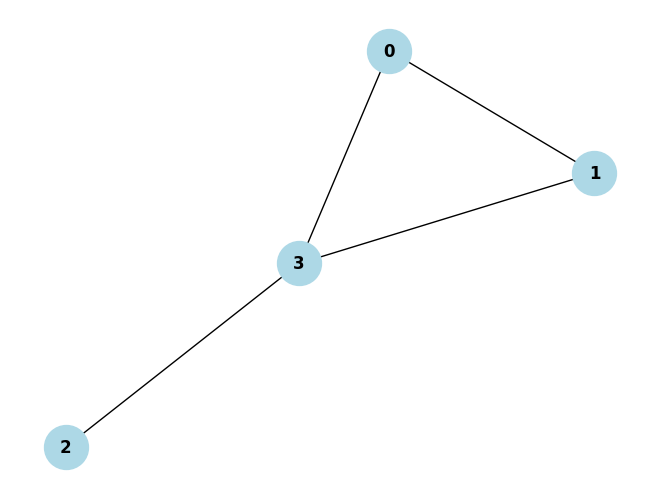

In [33]:
view_samples0=[]
view_samples=[]
view_initial=[]
view_final=[]
for i in range(1):
    num_vectors=real_num
    num_vectors = real_num
    num_upper_triangle_terms = int((num_vectors * (num_vectors - 1)) / 2)
    matrix = torch.zeros(num_vectors+ num_upper_triangle_terms, num_vectors+ num_upper_triangle_terms)


    k= 0
    # Calculate pairwise distances
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            matrix[i,num_vectors+ k] = 1
            matrix[j,num_vectors+ k] = 1
            matrix[num_vectors+ k,i] = 1
            matrix[num_vectors+ k,j] = 1



            k=k+ 1

    adjacency_matrix = matrix




    num_nodes = adjacency_matrix.size(0)


    updated_edge_index = [[], []]


    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] == 1:
                updated_edge_index[0].append(i)  # Source node
                updated_edge_index[1].append(j)  # Target node


    edge_index = torch.tensor(updated_edge_index).to(device)
    n_nodes= num_nodes
    data2=torch.randn(10,2).to(device)
    view_initial.append(data2)

    samples,samples0 = sample(model, data2)
    final=samples[49]
    final=torch.tensor(final)
    view_samples.append(samples)
    view_samples0.append(samples0)
    view_final.append(final)
    recon= loaded_auto.decode(final.to(device),edge_index)
    edgey= edge_index





    des= recon[:num_vectors]
    ans= des[:,:5]

    max_values, _ = torch.max(ans, dim=1, keepdim=True)


    ans_binary = torch.where(ans == max_values, torch.tensor(1.0), torch.tensor(0.0))

    print("Result:")
    print(ans_binary)

    row_values = []

    # Iterate over the rows of the tensor
    for row in ans_binary:
        # Convert the row to a binary string
        binary_str = ''.join([str(int(x)) for x in row.tolist()])
        # Map the binary string to the corresponding row value
        if binary_str == '01000':
            row_values.append(6)

        elif binary_str == '00100':
            row_values.append(7)
        elif binary_str == '00010':
            row_values.append(8)
        elif binary_str == '00001':
            row_values.append(9)
        else:
            # If the binary string doesn't match any condition, append 0
            row_values.append(0)

    # Convert the list of row values to a tensor
    new_tensor = torch.tensor(row_values)

    print("New Tensor:")
    print(new_tensor)
    augmented_features_matrix = recon

    node_features_matrix = augmented_features_matrix[:num_vectors, :]
    edge_features_matrix = augmented_features_matrix[num_vectors:, :]  # Extract edge features
    row_averages = torch.mean(edge_features_matrix, dim=1)
    row_averages = (row_averages > 0).float()


    adjacency_matrix_dec = torch.zeros((num_vectors, num_vectors), dtype=torch.int)

    k= 0

    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            adjacency_matrix_dec[i][j]=row_averages[k]
            adjacency_matrix_dec[j][i]=row_averages[k]



            k=k+ 1
    print(adjacency_matrix_dec)

    edge_list = [(i, j) for i in range(adjacency_matrix_dec.size(0)) for j in range(adjacency_matrix_dec.size(1)) if adjacency_matrix_dec[i][j] != 0]


    edge_index = torch.tensor(edge_list).t().contiguous()

    print("Edge Index:")
    print(edge_index)


    import torch
    from rdkit import Chem



    # Convert node features and edge index to an RDKit Mol object
    mol = Chem.RWMol()

    # Keep track of the bonds already added to avoid duplicates
    added_bonds = set()

    # Add atoms to the molecule based on node features (data.x)
    for atom_type in new_tensor:
        atom = Chem.Atom(atom_type.item())
        mol.AddAtom(atom)

    # Add bonds to the molecule based on edge connections (data.edge_index)
    for i, j in edge_index.t().tolist():
        # Check if the bond already exists
        if (i, j) not in added_bonds:
            mol.AddBond(i, j, Chem.BondType.SINGLE)
            added_bonds.add((i, j))
            added_bonds.add((j, i))  # Assuming the graph is undirected

    # Convert the RDKit Mol object to a SMILES string
    smiles = Chem.MolToSmiles(mol)
    generated_smiles= smiles

    print("SMILES:", smiles)


    # Check if the molecule is valid (i.e., if it has correct atom types, valence, etc.)
    def is_valid_molecule(mol):
        if mol is None:
            return False
        return Chem.SanitizeMol(mol) == Chem.SanitizeFlags.SANITIZE_NONE

    # Example usage:
    mol = Chem.MolFromSmiles(smiles)
    valid = is_valid_molecule(mol)




    print(valid)
    import torch
    import networkx as nx
    import matplotlib.pyplot as plt

    # Given adjacency matrix (renamed as adj_matrix)
    adj_matrix = adjacency_matrix_dec

    # Convert adj_matrix to NumPy array and then to NetworkX graph
    G = nx.from_numpy_array(adj_matrix.numpy())

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Layout for graph visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12, font_weight='bold')
    plt.show()